## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-01-01 23:20:21--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-01-01 23:20:22 (8.11 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 56,  0, ...,  1, 47, 60],
       [83, 50, 68, ..., 63, 73,  5],
       [83,  1, 62, ..., 59,  1, 59],
       ...,
       [83, 53,  1, ..., 12,  0, 58],
       [83, 50,  1, ..., 46, 72, 56],
       [83, 59,  1, ..., 45, 56,  1]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [19]:
class RNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)

        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True).to(device)

In [20]:
def train(model, batch, optimizer, criterion):
    model.zero_grad()
    hidden = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch.transpose(0,1):
        hidden, logits = model(x_t, hidden)
        logprobs.append(logits)

    logprobs = torch.stack(logprobs, dim=1)
    pred = logprobs[:, :-1]
    actual_tokens = batch[:, 1:]

    loss = criterion(
        pred.contiguous().view(-1, len(tokens)),
        actual_tokens.contiguous().view(-1)
    )

    loss.backward()
    optimizer.step()

    return loss

Training complete in 9m 35s


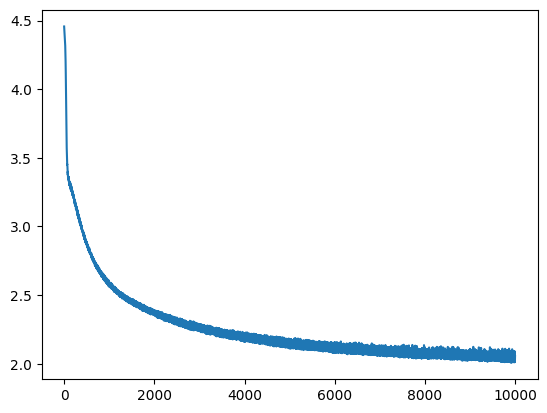

In [27]:
import time


n_epochs = 10000

model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

loss_history = []
start_time = time.time()

model.to(device)
model.train()

for epoch in range(1, n_epochs + 1):
    batch = torch.tensor(next(generate_chunk()), dtype=torch.int64)
    loss = train(model, batch.to(device), optimizer, criterion)
    loss_history.append(loss.cpu().detach().numpy())

time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

plt.plot(loss_history,label='loss')
plt.show()

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [83]:
def generate_sample(model, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = model.initial_state(batch_size=1)
    model.eval()

    for i in range(len(seed_phrase) - 1):
        hidden, _ = model(x_sequence[:, i], hidden)

    for _ in range(max_length - len(seed_phrase)):
        hidden, logp_next = model(x_sequence[:, -1], hidden)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]

        next_ix = np.random.choice(len(token_to_idx), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [86]:
print(generate_sample(model, ' сенчик и саня', max_length=500, temperature=0.6))

<sos> сенчик и саня нежно
готорила в приводанье,
перод его поторейны свои всех пороб постала в сосодной он в омено поров был ливый добранним не были дворной долженно стараном подамали с нон каждым старыль ее на подавные старанный середелей приводин ее насвоей.



xi

и на мольки разлачивае каждя мечты,
как до страстит
остарит нам, слава в заветились простовались в нам в от постенный рудь.



xxxiv

и подоствие знально вак муля летет
он красой.
заветы,
всё не без довят, пред нов сердце и вздверь вол н


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [87]:
seed_phrase = ' мой дядя самых честных правил'

In [88]:
generated_phrases = [generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.6).replace('<sos>', '') for _ in range(10)]

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [89]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!